# Performing linear regression with maximum likelihood estimation

Using the agent to infer linear generating function parameters instead of hidden states via gradient descent instead of analytic calculation of the maximum likelihood estimate.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 3 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys
import torch

from matplotlib import cm
from torch.distributions import Normal
from typing import Union

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_environment

mpl.style.use("seaborn-deep")

This notebook recapitulates the ideas from the previous notebooks but uses gradient descent instead of the analytic update rules for maximum likelihood estimation. In Chapter 2, we used gradient descent for hidden state estimation. This notebook will be instead be estimating the parameters of the linear model, assuming that $x$ is known. We will use the following objective function, the negative log likelihood

$$
    -\ell(\theta) = - \sum_{i=1}^N \log \mathcal{N}(y^{(i)}; \beta_0 + \beta_1 x^{(i)}, \sigma^2_y)
$$

where $\theta \in \left \{\beta_0, \beta_1 \right \}$. We can obtain the log-likelihood function over samples by modifying the MLE objective defined in Notebook 2.9. 

In [2]:
def generating_function(beta_0: float, beta_1: float, x: float) -> float:
    return beta_1 * x + beta_0

def mle_objective(beta_0: float, beta_1: float) -> torch.tensor:
    
    # Parameters
    var_y  = 0.5       # Likelihood variance
    
    # Linear genearting function
    mu_y   = generating_function(beta_0=beta_0, beta_1=beta_1, x=x_star)
    
    # Calculate log-likelihood over samples    
    log_likelihood = Normal(loc=mu_y, scale=np.sqrt(var_y)).log_prob(y).sum(axis=0)
    
    return -log_likelihood

In gradient descent we update our parameter in the direction of the negative gradient along our loss function. This means that in order to perform gradient descent we need to pick a starting position on the loss function (the initialization), a learning rate specifying how big we are going to step down the loss function, and then loop through the update process over $j$ iterations. The gradient descent process is captured by the following equation:

$$
\theta^{(j+1)} \gets \theta^{(j)} - \kappa \frac{\partial \ell(\theta)}{\partial \theta^{(j)}}
$$

In the code below, we initialize the parameters randomly from -100 to 100. The initial loss will be calculated at this random initialization for the parameters. Note that the parameters include two values: $\beta_0$ and $\beta_1$. `pytorch` will automatically determine the gradient update for both of these parameters simultaneously.

In [18]:
# beta_0_init = np.random.uniform(low=-100, high=100)
# beta_1_init = np.random.uniform(low=-100, high=100)

beta_0_init = -97.951
beta_1_init = -26.239

theta = np.array([beta_0_init, beta_1_init])

Now we specify the code for gradient descent, also modified from Notebook 2.9. The only change here is to specify $\theta$ as an input to the function and allowing the objective function to take $\theta$, $x$, and $y$ as inputs.

In [19]:
def gradient_descent(kappa: float, 
                     n_iterations: int, 
                     theta: np.array, 
                     obj: callable):
    
    print(f"Initializing theta at {theta}.")
    
    # Initialize empty history arrays
    theta_history = torch.zeros((n_iterations, 2))
    loss_history  = torch.zeros((n_iterations, 2))
    
    # Turn x into a Torch tensor which is differentiable
    theta = torch.tensor(theta, requires_grad=True)
    
    # Calculate loss at initialization
    loss = obj(theta[0], theta[1])
    
    # Add initialization values to history (j=0)
    theta_history[0] = theta
    loss_history[0]  = loss
    
    # Gradient descent algorithm (for j+1...n_iterations)
    for j in range(n_iterations-1):
        obj_theta = obj(theta[0], theta[1])  # Compute loss
        obj_theta.backward()   # Compute gradient of tensor
        
        with torch.no_grad():
            theta -= (kappa * theta.grad)   # Step in direction of gradient
            theta.grad.zero_()              # Zero out the gradients
        
        # Recalculate loss
        loss = obj(theta[0], theta[1])
        
        # Append to history
        theta_history[j+1] = theta
        loss_history[j+1]  = loss

    print(f"Final value of theta: {np.round(theta.detach().numpy(), 3)}")
    history = {"theta": theta_history, "loss": loss_history}
    return history

Next we will create the environment and generate data samples.

In [20]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1     # Standard deviation of sensory data
}

env = create_environment(name="static_linear", params=env_params)

# Generate data from the support of x
N       = 500                                        # Number of samples
x_range = np.linspace(start=0.01, stop=5, num=500)   # Support of x
x_star  = np.random.choice(x_range, size=N)          # N random external states
y       = np.zeros(N)                                # Empty array for N data samples

# Generate N samples
for idx, x in enumerate(x_star):
    env.build(x)
    y[idx] = env.generate()

# Convert numpy array for data into tensor
y      = torch.tensor(y)
x_star = torch.tensor(x_star)

And run gradient descent.

In [27]:
mle_history = gradient_descent(
    kappa=0.0001, 
    n_iterations=1000, 
    theta=theta, 
    obj=mle_objective)

Initializing theta at [-97.951 -26.239].
Final value of theta: [3.138 1.982]


In [28]:
theta_history = mle_history["theta"]
loss_history = mle_history["loss"]

As we can see, gradient descent was successful. To visualize the results we plot the iterative updates to the values of $\beta_0$ and $\beta_1$ on the surface of the loss function in 2D and 3D.

/tmp/ipykernel_44863/2106952313.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(fill)


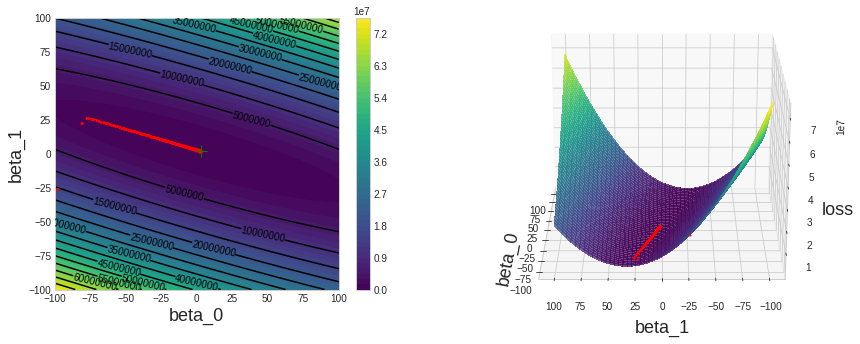

In [30]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(facecolor=(1,1,1), figsize=(14,5))

""" LEFT PLOT """
ax = fig.add_subplot(1, 2, 1)

# Set up grid
b0_range = np.linspace(-100, 100, 200)
b1_range = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(b0_range, b1_range)

# Vectorize NLL and compute the costs at all combinations of beta_0 and beta_1
nll_mle_vec = np.vectorize(mle_objective)
z = nll_mle_vec(X, Y)

# Plot the contours of the costs and fill them in
contours = ax.contour(X, Y, z, levels=15, colors='k')
fill = ax.contourf(X, Y, z, levels=50, cmap="viridis")

# Compute the updates of beta_0 and beta_1 for each iteration of gradient descent
beta_0 = [theta[0].detach().numpy() for theta in theta_history]
beta_1 = [theta[1].detach().numpy() for theta in theta_history]

# Plot the beta_0 and beta_1 updates across the loss function
ax.plot(beta_0, beta_1, "r>", ms=2.5)
ax.plot(3, 2, marker="+", color="green", markersize=12)   # True generating parameters

# Axis labels
ax.set_xlabel("beta_0", fontsize=18)
ax.set_ylabel("beta_1", fontsize=18)

# Labels contours and add colorbar
plt.clabel(contours)
plt.colorbar(fill)

""" RIGHT PLOT """
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot 3D negative log-likelihood
ax.plot_surface(X, Y, z, cmap=cm.viridis, antialiased=False, alpha=0.75)

# Compute the costs at each weight update
loss_at_theta = [mle_objective(theta[0], theta[1]).tolist() for theta in theta_history]

# Plot update along loss surface 
ax.plot(beta_0, beta_1, loss_at_theta, "r>", ms=1.5, zorder=10)

# Change 3D plot camera view
ax.view_init(20, 180)

# Axis labels
ax.set_xlabel("beta_0", fontsize=18)
ax.set_ylabel("beta_1", fontsize=18)
ax.set_zlabel("loss", fontsize=18)

ax.dist = 7.5